In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_size = 224
batch_size = 64
num_classes = 27
learning_rate = 3e-4
EPOCHS = 15

train_dir = 'RSCD/RSCD_dataset/train_50k'
val_dir = 'RSCD/RSCD_dataset/validation'
test_dir = 'RSCD/RSCD_dataset/test'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class AlbumentationsDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.classes = sorted([d for d in os.listdir(root_dir)
                               if os.path.isdir(os.path.join(root_dir, d)) and d != ".DS_Store"])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []
        for cls in self.classes:
            cls_path = os.path.join(root_dir, cls)
            for img in os.listdir(cls_path):
                if img.lower().endswith(('jpg', 'jpeg', 'png')) and img != ".DS_Store":
                    self.image_paths.append(os.path.join(cls_path, img))
                    self.labels.append(self.class_to_idx[cls])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Failed to load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = self.transform(image=image)
        return augmented['image'], torch.tensor(label)


In [4]:
train_transform = A.Compose([
    A.RandomResizedCrop((img_size, img_size), scale=(0.85, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.MotionBlur(p=0.2),
    A.RandomShadow(p=0.2),
    A.RandomRain(p=0.1),
    A.RandomSnow(p=0.1),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_dataset = AlbumentationsDataset(train_dir, train_transform)
val_dataset = AlbumentationsDataset(val_dir, val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [5]:
# Load EfficientNetV2-M with pretrained weights
weights = EfficientNet_V2_M_Weights.DEFAULT
model = efficientnet_v2_m(weights=weights)

# Replace classifier head for 27 classes
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512, num_classes)
)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /home/jovyan/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth


100%|█████████████████████████████████████████████████████████████████████████████████| 208M/208M [00:01<00:00, 169MB/s]


In [6]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

In [7]:
best_acc = 0.0
train_loss = []
train_accu = []
val_accu = []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    scheduler.step()

    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    train_loss.append(running_loss)
    train_accu.append(train_acc)

    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.4f}")
    val_accu.append(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_efficientnet_v2_m_model.pth")
        print("Best model saved!")

print(f"\nTraining completed. Best validation accuracy: {best_acc:.4f}")

Epoch 1/15: 100%|███████████████████████████████████████████████████████████████| 21094/21094 [1:07:44<00:00,  5.19it/s]

Epoch 1, Loss: 34364.0162, Train Accuracy: 0.6066


Validation Accuracy: 0.6888
Best model saved!


Epoch 2/15: 100%|███████████████████████████████████████████████████████████████| 21094/21094 [1:07:25<00:00,  5.21it/s]

Epoch 2, Loss: 31727.2119, Train Accuracy: 0.6531


Validation Accuracy: 0.7092
Best model saved!


Epoch 3/15: 100%|███████████████████████████████████████████████████████████████| 21094/21094 [1:07:28<00:00,  5.21it/s]

Epoch 3, Loss: 31089.5869, Train Accuracy: 0.6641


Validation Accuracy: 0.7055


Epoch 4/15: 100%|███████████████████████████████████████████████████████████████| 21094/21094 [1:07:28<00:00,  5.21it/s]

Epoch 4, Loss: 30741.7607, Train Accuracy: 0.6703


Validation Accuracy: 0.7139
Best model saved!


Epoch 5/15: 100%|███████████████████████████████████████████████████████████████| 21094/21094 [1:07:37<00:00,  5.20it/s]

Epoch 5, Loss: 30414.6148, Train Accuracy: 0.6757


Validation Accuracy: 0.7277
Best model saved!


Epoch 6/15: 100%|███████████████████████████████████████████████████████████████| 21094/21094 [1:07:38<00:00,  5.20it/s]

Epoch 6, Loss: 30053.0063, Train Accuracy: 0.6826


Validation Accuracy: 0.7252


Epoch 7/15: 100%|███████████████████████████████████████████████████████████████| 21094/21094 [1:07:48<00:00,  5.19it/s]

Epoch 7, Loss: 29634.8421, Train Accuracy: 0.6901


Validation Accuracy: 0.7407
Best model saved!


Epoch 8/15: 100%|███████████████████████████████████████████████████████████████| 21094/21094 [1:07:37<00:00,  5.20it/s]

Epoch 8, Loss: 29118.7501, Train Accuracy: 0.6996


Validation Accuracy: 0.7387


Epoch 9/15: 100%|███████████████████████████████████████████████████████████████| 21094/21094 [1:07:58<00:00,  5.17it/s]

Epoch 9, Loss: 28510.2581, Train Accuracy: 0.7109


Validation Accuracy: 0.7502
Best model saved!


Epoch 10/15: 100%|██████████████████████████████████████████████████████████████| 21094/21094 [1:07:37<00:00,  5.20it/s]

Epoch 10, Loss: 27836.4032, Train Accuracy: 0.7231


Validation Accuracy: 0.7535
Best model saved!


Epoch 11/15: 100%|██████████████████████████████████████████████████████████████| 21094/21094 [1:07:33<00:00,  5.20it/s]

Epoch 11, Loss: 27100.1298, Train Accuracy: 0.7371


Validation Accuracy: 0.7685
Best model saved!


Epoch 12/15: 100%|██████████████████████████████████████████████████████████████| 21094/21094 [1:07:34<00:00,  5.20it/s]

Epoch 12, Loss: 26338.5028, Train Accuracy: 0.7518


Validation Accuracy: 0.7767
Best model saved!


Epoch 13/15: 100%|██████████████████████████████████████████████████████████████| 21094/21094 [1:07:38<00:00,  5.20it/s]

Epoch 13, Loss: 25596.8135, Train Accuracy: 0.7661


Validation Accuracy: 0.7811
Best model saved!


Epoch 14/15: 100%|██████████████████████████████████████████████████████████████| 21094/21094 [1:07:27<00:00,  5.21it/s]

Epoch 14, Loss: 24972.2215, Train Accuracy: 0.7779


Validation Accuracy: 0.7888
Best model saved!


Epoch 15/15: 100%|██████████████████████████████████████████████████████████████| 21094/21094 [1:07:49<00:00,  5.18it/s]

Epoch 15, Loss: 24560.0445, Train Accuracy: 0.7862


Validation Accuracy: 0.7900
Best model saved!

Training completed. Best validation accuracy: 0.7900


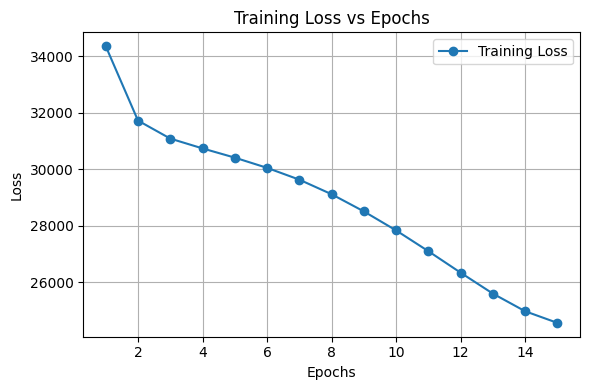

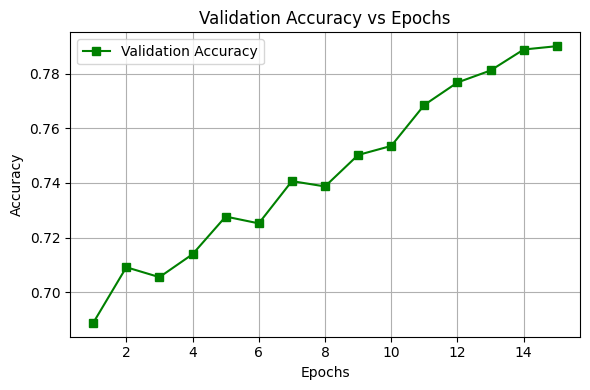

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, EPOCHS + 1), train_loss, marker='o', label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Loss vs Epoch.jpg", format='jpg', dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(range(1, EPOCHS + 1), val_accu, marker='s', color='green', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy vs Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("Validation vs epoch.jpg", format='jpg', dpi=300)
plt.show()

In [12]:
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
from tqdm import tqdm
img_size = 224
batch_size = 64
num_classes = 27
test_dir = 'RSCD/RSCD_dataset/test'  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

val_test_transform = A.Compose([
    A.Resize(img_size, img_size),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

def extract_label_from_filename(filename):
    name = os.path.splitext(filename)[0]
    label = name.split('-', 1)[1]
    return label


all_labels = set()
for fname in os.listdir(test_dir):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        label = extract_label_from_filename(fname)
        all_labels.add(label)

label_to_idx = {label: idx for idx, label in enumerate(sorted(all_labels))}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

class FlatFolderTestDataset(Dataset):
    def __init__(self, folder, transform):
        self.image_paths = []
        self.labels = []
        for fname in os.listdir(folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                label_str = extract_label_from_filename(fname)
                if label_str in label_to_idx:
                    self.image_paths.append(os.path.join(folder, fname))
                    self.labels.append(label_to_idx[label_str])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        label = self.labels[idx]

        image = cv2.imread(path)
        if image is None:
            raise ValueError(f"Failed to read image: {path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        augmented = self.transform(image=image)
        image_tensor = augmented['image']

        return image_tensor, torch.tensor(label)

test_dataset = FlatFolderTestDataset(test_dir, val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

weights = EfficientNet_V2_M_Weights.DEFAULT
model = efficientnet_v2_m(weights=weights)

num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512, num_classes)
)

model = model.to(device)

checkpoint_path = "best_efficientnet_v2_m_model.pth"  # Update path if needed
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on test set"):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

if total == 0:
    print("No valid test images found.")
else:
    accuracy = correct / total
    print(f"\nTest Accuracy: {accuracy:.4f} ({correct}/{total})")

Using device: cuda


Evaluating on test set: 100%|█████████████████████████████████████████████████████████| 774/774 [00:50<00:00, 15.31it/s]


Test Accuracy: 0.8849 (43804/49500)


In [1]:
import torch
import torch.nn as nn
import os
from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights

num_classes = 27
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = EfficientNet_V2_M_Weights.DEFAULT
model = efficientnet_v2_m(weights=weights)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(512, num_classes)
)
model = model.to(device)

checkpoint_path = "best_efficientnet_v2_m_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()


Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /Users/jahnavikalla/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|████████████████████████████████████████| 208M/208M [00:54<00:00, 3.98MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

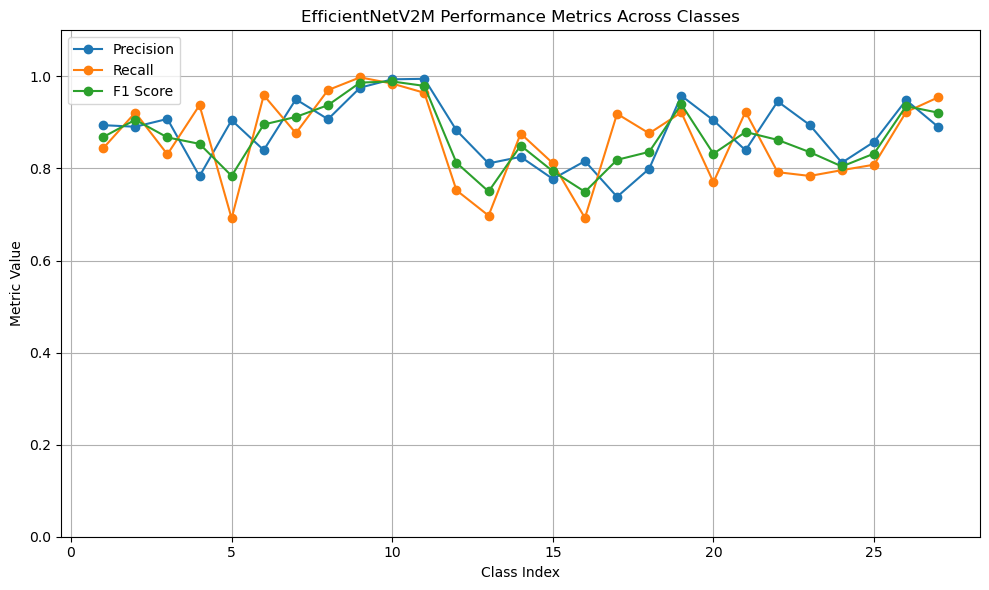

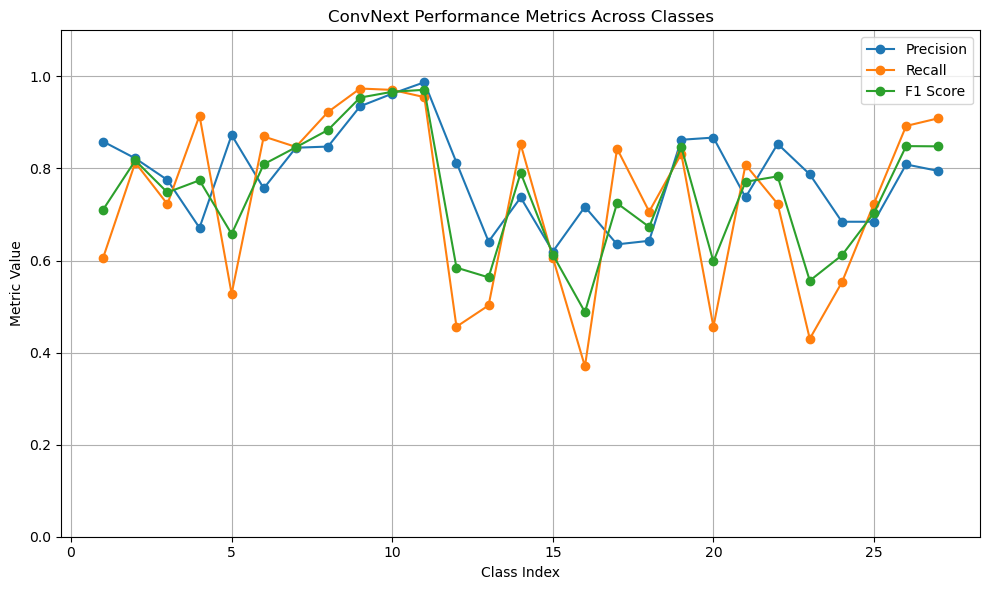

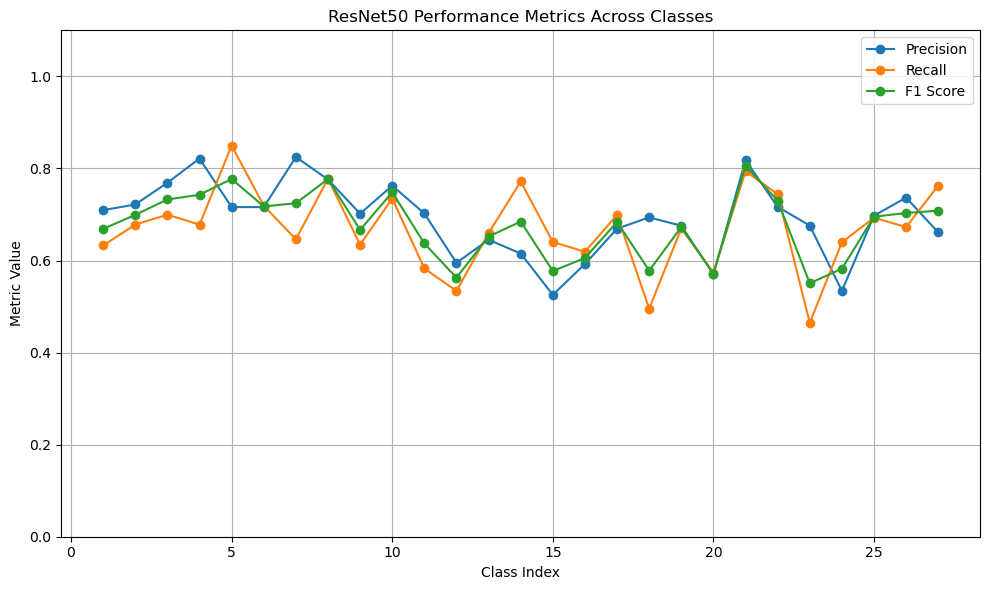

In [3]:
import matplotlib.pyplot as plt

# ---- DATA ----
metrics_data = {
    'EfficientNetV2M': {
        'Accuracy': [0.8940, 0.8906, 0.9075, 0.7831, 0.9048, 0.8398, 0.9502, 0.9069, 0.9755, 0.9936, 0.9947,
                     0.8827, 0.8110, 0.8252, 0.7772, 0.8159, 0.7384, 0.7993, 0.9580, 0.9046, 0.8394, 0.9456,
                     0.8944, 0.8125, 0.8577, 0.9484, 0.8901],
        'Precision': [0.8940, 0.8906, 0.9075, 0.7831, 0.9048, 0.8398, 0.9502, 0.9069, 0.9755, 0.9936, 0.9947,
                      0.8827, 0.8110, 0.8252, 0.7772, 0.8159, 0.7384, 0.7993, 0.9580, 0.9046, 0.8394,
                      0.9456, 0.8944, 0.8125, 0.8577, 0.9484, 0.8901],
        'Recall': [0.8438, 0.9213, 0.8306, 0.9374, 0.6915, 0.9591, 0.8766, 0.9702, 0.9979, 0.9843, 0.9643,
                   0.7525, 0.6975, 0.8757, 0.8113, 0.6925, 0.9187, 0.8762, 0.9217, 0.7700, 0.9230, 0.7919,
                   0.7837, 0.7963, 0.8081, 0.9226, 0.9545],
        'F1 Score': [0.8682, 0.9057, 0.8674, 0.8534, 0.7839, 0.8955, 0.9119, 0.9375, 0.9865, 0.9889, 0.9793,
                     0.8124, 0.7500, 0.8497, 0.7939, 0.7492, 0.8187, 0.8360, 0.9395, 0.8319, 0.8792, 0.8620,
                     0.8354, 0.8043, 0.8322, 0.9353, 0.9211]
    },
    'ConvNext': {
        'Accuracy': [0.8584, 0.8219, 0.7750, 0.6710, 0.8726, 0.7567, 0.8450, 0.8475, 0.9350, 0.9624, 0.9872,
                     0.8129, 0.6411, 0.7369, 0.6194, 0.7167, 0.6351, 0.6428, 0.8623, 0.8670, 0.7372, 0.8533,
                     0.7872, 0.6842, 0.6842, 0.8087, 0.7946],
        'Precision': [0.8584, 0.8219, 0.7750, 0.6710, 0.8726, 0.7567, 0.8450, 0.8475, 0.9350, 0.9624, 0.9872,
                      0.8129, 0.6411, 0.7369, 0.6194, 0.7167, 0.6351, 0.6428, 0.8623, 0.8670, 0.7372, 0.8533,
                      0.7872, 0.6842, 0.6842, 0.8087, 0.7946],
        'Recall': [0.6062, 0.8128, 0.7226, 0.9149, 0.5277, 0.8694, 0.8468, 0.9226, 0.9736, 0.9706, 0.9549,
                   0.4562, 0.5025, 0.8523, 0.6062, 0.3700, 0.8430, 0.7063, 0.8315, 0.4562, 0.8081, 0.7230,
                   0.4300, 0.5525, 0.7238, 0.8923, 0.9089],
        'F1 Score': [0.7106, 0.8173, 0.7479, 0.7742, 0.6577, 0.8091, 0.8459, 0.8835, 0.9539, 0.9665, 0.9708,
                   0.5845, 0.5634, 0.7904, 0.6128, 0.4880, 0.7244, 0.6730, 0.8466, 0.5979, 0.7710, 0.7828,
                   0.5562, 0.6113, 0.7035, 0.8485, 0.8480]
    },
    'ResNet50': {
        'Accuracy': [0.7094, 0.7217, 0.7689, 0.8214, 0.7160, 0.7160, 0.8248, 0.7760, 0.7018, 0.7626, 0.7022,
                     0.5950, 0.6450, 0.6152, 0.5255, 0.5923, 0.6692, 0.6937, 0.6755, 0.5702, 0.8179, 0.7165,
                     0.6759, 0.5341, 0.6973, 0.7367, 0.6609],
        'Precision': [0.7094, 0.7217, 0.7689, 0.8214, 0.7160, 0.7160, 0.8248, 0.7760, 0.7018, 0.7626, 0.7022,
                      0.5950, 0.6450, 0.6152, 0.5255, 0.5923, 0.6692, 0.6937, 0.6755, 0.5702, 0.8179, 0.7165,
                      0.6759, 0.5341, 0.6973, 0.7367, 0.6609],
        'Recall': [0.6327, 0.6780, 0.6996, 0.6779, 0.8497, 0.7191, 0.6460, 0.7776, 0.6345, 0.7346, 0.5828,
                   0.5339, 0.6593, 0.7717, 0.6402, 0.6191, 0.6989, 0.4954, 0.6696, 0.5731, 0.7940, 0.7441,
                   0.4645, 0.6396, 0.6930, 0.6726, 0.7628],
        'F1 Score': [0.6688, 0.6991, 0.7326, 0.7428, 0.7771, 0.7175, 0.7245, 0.7768, 0.6665, 0.7483, 0.6370,
                     0.5628, 0.6521, 0.6846, 0.5772, 0.6054, 0.6838, 0.5780, 0.6726, 0.5716, 0.8058, 0.7300,
                     0.5506, 0.5821, 0.6952, 0.7032, 0.7082]
    }
}

# ---- PLOTTING ----
for model_name, metrics in metrics_data.items():
    plt.figure(figsize=(10, 6))
    x = list(range(1, len(metrics['Accuracy']) + 1))
    plt.plot(x, metrics['Precision'], marker='o', label='Precision')
    plt.plot(x, metrics['Recall'], marker='o', label='Recall')
    plt.plot(x, metrics['F1 Score'], marker='o', label='F1 Score')
    plt.title(f'{model_name} Performance Metrics Across Classes')
    plt.xlabel('Class Index')
    plt.ylabel('Metric Value')
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

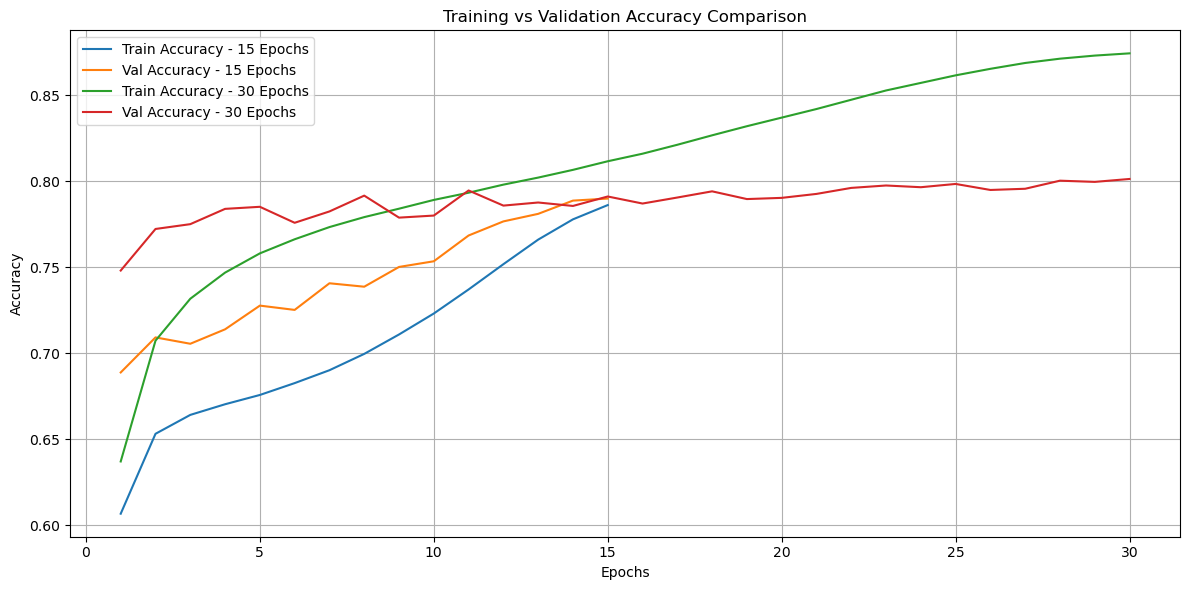

In [8]:
import matplotlib.pyplot as plt

# Epoch numbers
epochs_15 = list(range(1, 16))
epochs_30 = list(range(1, 31))

# Accuracies for 15 epochs
train_acc_15 = [0.6066, 0.6531, 0.6641, 0.6703, 0.6757, 0.6826, 0.6901, 0.6996, 0.7109, 0.7231, 0.7371, 0.7518, 0.7661, 0.7779, 0.7862]
val_acc_15 = [0.6888, 0.7092, 0.7055, 0.7139, 0.7277, 0.7252, 0.7407, 0.7387, 0.7502, 0.7535, 0.7685, 0.7767, 0.7811, 0.7888, 0.7900]

# Accuracies for 30 epochs
train_acc_30 = [0.6370, 0.7073, 0.7317, 0.7469, 0.7581, 0.7663, 0.7734, 0.7792, 0.7841, 0.7892, 0.7934, 0.7981, 0.8022, 0.8067, 0.8117,
                0.8161, 0.8213, 0.8268, 0.8321, 0.8371, 0.8421, 0.8475, 0.8529, 0.8573, 0.8617, 0.8655, 0.8689, 0.8714, 0.8732, 0.8745]
val_acc_30 = [0.7481, 0.7723, 0.7751, 0.7840, 0.7852, 0.7759, 0.7825, 0.7917, 0.7789, 0.7801, 0.7947, 0.7859, 0.7877, 0.7857, 0.7912,
              0.7871, 0.7906, 0.7942, 0.7897, 0.7904, 0.7927, 0.7962, 0.7976, 0.7966, 0.7985, 0.7950, 0.7957, 0.8004, 0.7997, 0.8014]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs_15, train_acc_15, label='Train Accuracy - 15 Epochs')
plt.plot(epochs_15, val_acc_15, label='Val Accuracy - 15 Epochs')
plt.plot(epochs_30, train_acc_30, label='Train Accuracy - 30 Epochs')
plt.plot(epochs_30, val_acc_30, label='Val Accuracy - 30 Epochs')

plt.title('Training vs Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('acccomp.jpg')
plt.tight_layout()
plt.show()

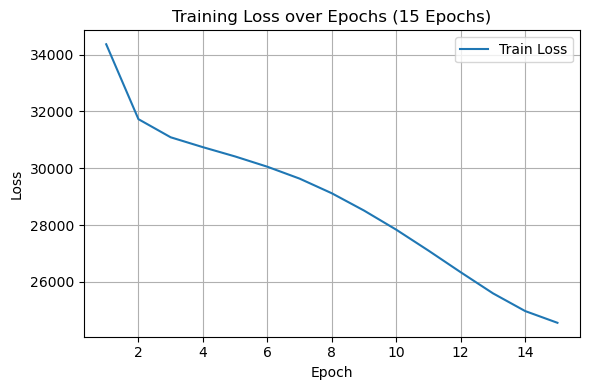

In [6]:
import matplotlib.pyplot as plt

# Epoch numbers (1 to 15)
epochs_15 = list(range(1, 16))

# Provided training loss values for each epoch
train_loss_15 = [
    34364.0162, 31727.2119, 31089.5869, 30741.7607, 30414.6148, 30053.0063,
    29634.8421, 29118.7501, 28510.2581, 27836.4032, 27100.1298, 26338.5028,
    25596.8135, 24972.2215, 24560.0445
]

plt.figure(figsize=(6,4))
plt.plot(epochs_15, train_loss_15, label='Train Loss', color='tab:blue')
plt.title('Training Loss over Epochs (15 Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('TrainvsLoss.jpg')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


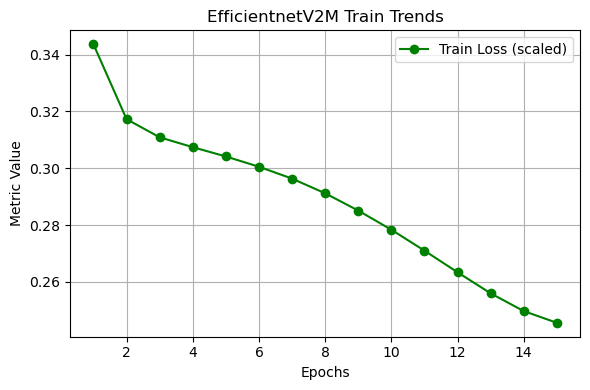

In [8]:
import matplotlib.pyplot as plt

epochs = list(range(1, 16))
train_loss_15 = [
    34364.0162, 31727.2119, 31089.5869, 30741.7607, 30414.6148, 30053.0063,
    29634.8421, 29118.7501, 28510.2581, 27836.4032, 27100.1298, 26338.5028,
    25596.8135, 24972.2215, 24560.0445]
train_loss_scaled = [x/100000 for x in train_loss]

plt.figure(figsize=(6, 4))  # Smaller figure size
plt.plot(epochs, train_loss_scaled, label='Train Loss (scaled)', color='green')
plt.title('EfficientnetV2M Train Trends')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
